# 2) Solens upp- och nedgång 
Modul 2: linjära ekvationssystem och Modul 3: Kurvanpassning

Tabell 1 innehåller medelvärdet i minuter som solen är uppe i Stockholm under årets tolv månader.

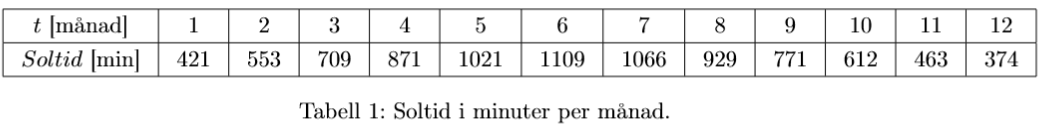

I denna uppgift ska du skriva ett Python-program som gör kurvanpassningarna i uppgifterna
a), c)-e) till data i tabellen.

För varje kurvanpassning:

•plotta den anpassade modellen tillsammans med data från tabellen,

•beräkna minstakvadratfelet (i kvadrat),

•du **får** använda den inbyggda functionen numpy.vander i uppgift a) men du **får inte**
använda följande Python-funktioner: numpy.polyfit; numpy.polyval,

•du **får inte** använda den inbyggda funtionen scipy.optimize.curve_fit i uppgift c till
e).

## 2.a.b) 

Modell: ett interpolationspolynom till alla data.

Vilket gradtal blir det på polynomet?

Beräkna interpolationspolynomet på tre olika sätt:

•Naiv ansats: p1(t) = c0 + c1t + c2t2 + ···

•Centrerad ansats: p2(t) = c0 + c1(t −tm) + c2(t −tm)2 ···, där tm är medelvärdet
i tidsvektorn t = [1 2 ···12]T .

•Newtons ansats: p3(t) = c0 + c1(t−t1) + c2(t−t1)(t−t2) ···, där t1 är komponent
1 i tidsvektorn t osv.

Evaluera polynomen p1,p2,p3 i 1000 punkter mellan 0 och 12 och räkna ut maximala
skillnaden på intervallet mellan p1,p2,p3. 

Du behöver bara plotta polynomet för en av
ansatserna ovan. 

Varför?

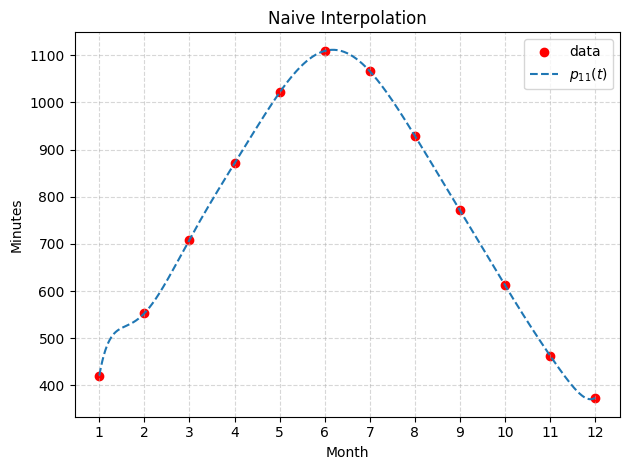

With naive ansatz p(x) has SE = 9.656598722179142e-14
With centered ansatz p(x) has SE = 5.0884532369082343e-23
With Newton ansatz p(x) has SE = 1.0985992510469899e-24


Condition number for naive ansatz is 1.1605354618836394e+16
Condition number for centered ansatz is 495102791.73094493
Condition number for newton ansatz is 217010224.00010672

 
Maximum differences between interpolation methods:
Max difference between p1 (naive) and p2 (centered): 9.704340e-07
Max difference between p1 (naive) and p3 (Newton):   9.704579e-07
Max difference between p2 (centered) and p3 (Newton): 2.955858e-11


In [46]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
from typing import Callable, Optional

plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = "dashed"
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["legend.fancybox"] = True


data: list = [
    421,
    553,
    709,
    871,
    1021,
    1109,
    1066,
    929,
    771,
    612,
    463,
    374,
]  # mins of sun / month

sun_data: np.ndarray = np.array(data)
t = np.linspace(1, 12, 12)
t_dense = np.linspace(1, 12, 1000)


def plot_model(
    t_data: np.ndarray,
    y_data: np.ndarray,
    model: Callable[[np.ndarray], np.ndarray],
    t_plot: Optional[np.ndarray] = None,
    title: str = "",
    model_label: str = "model",
    data_label: str = "data",
) -> None:
    t_data = np.asarray(t_data)
    y_data = np.asarray(y_data)

    if t_plot is None:
        t_plot = np.linspace(t_data.min(), t_data.max(), 400)

    fig, ax = plt.subplots()
    ax.scatter(t_data, y_data, color="red", label=data_label)
    ax.plot(t_plot, model(t_plot), linestyle="dashed", label=model_label)
    ax.set_title(title)
    ax.set_xlabel("Month")
    ax.set_ylabel("Minutes")
    ax.set_xticks(t_data)
    ax.legend(loc="best")
    fig.tight_layout()
    plt.show()


def SSE(residuals: np.ndarray) -> float:
    """
    Compute the sum of squared errors (SSE) for a set of residuals.

    Given residuals r_i = y_i - ŷ_i from a curve fit or regression model,
    this function returns

        SSE = sum_i r_i^2,

    which is the unnormalized least-squares error often used to quantify
    the total discrepancy between data and model. The input may be a
    1D array of length n or an (n, 1) column vector; it is flattened
    internally before computation.

    Args:
        residuals (np.ndarray):
            Array of residuals r_i = y_i - ŷ_i, shape (n,) or (n, 1).

    Returns:
        float:
            Sum of squared errors, SSE = Σ r_i^2.
    """
    sse = float(np.transpose(residuals) @ residuals)
    return sse


# Naive Interpolation
A_naive = np.vander(t, increasing=True)
c_naive = np.linalg.solve(A_naive, sun_data)
p_naive = poly.Polynomial(c_naive)
y_naive = p_naive(t)
residual_naive = sun_data - y_naive
naive_sse = SSE(residual_naive)

plot_model(
    t_data=t,
    y_data=sun_data,
    model=p_naive,
    t_plot=t_dense,
    title="Naive Interpolation",
    model_label=r"$p_{11}(t)$",
)

print(f"With naive ansatz p(x) has SE = {naive_sse}")

# Centered ansatz
t_m = np.mean(t)
tau = t - t_m
tau_dense = t_dense - t_m
A_centered = np.vander(tau, increasing=True)
c_centered = np.linalg.solve(A_centered, sun_data)
p_centered = poly.Polynomial(c_centered)
y_centered = p_centered(tau)
residual_centered = sun_data - y_centered
centered_sse = SSE(residual_centered)


# def centered_model(t):
#     return p_centered(t - t_m)

# plot_model(
#     t_data=t,
#     y_data=sun_data,
#     model=centered_model,
#     t_plot=t_dense,
#     title="Centered Interpolation",
#     model_label=r"$p_{11}(\tau), \tau = t- t_m$",
#

print(f"With centered ansatz p(x) has SE = {centered_sse}")


# Newton ansatz
def divided_differences(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Compute Newton's divided-difference coefficients for polynomial interpolation.

    Given data points (x_i, y_i), i = 0, ..., n-1, this function computes the
    coefficients c_0, ..., c_{n-1} of the Newton form of the interpolating
    polynomial

        p(x) = c_0
             + c_1 (x - x_0)
             + c_2 (x - x_0)(x - x_1)
             + ...
             + c_{n-1} (x - x_0)...(x - x_{n-2}).

    The coefficients are returned in a 1D array `coefficients` such that
    `coefficients[k] = c_k`.

    Args:
        x (np.ndarray): 1D array of distinct x-values (nodes), shape (n,).
        y (np.ndarray): 1D array of function values y_i = f(x_i), shape (n,).

    Returns:
        np.ndarray: 1D array of length n containing the divided-difference
        coefficients for the Newton interpolating polynomial.

    Raises:
        ValueError: If x and y do not have the same shape or if fewer than
        two data points are provided.
    """
    if x.shape != y.shape:
        raise ValueError("x and y must have the same shape")
    if x.ndim != 1:
        raise ValueError("x and y must be 1D arrays")
    if len(x) < 2:
        raise ValueError("At least two data points are required")

    n: int = len(x)
    coefficients = np.array(y, dtype=float)

    for j in range(1, n):
        coefficients[j:n] = (coefficients[j:n] - coefficients[j - 1 : n - 1]) / (
            x[j:n] - x[0 : n - j]
        )

    return coefficients


def newton_interpolation_matrix(x: np.ndarray) -> np.ndarray:
    """
    Build the Newton interpolation basis matrix for given nodes x.

    Given nodes x = (x_0, ..., x_{n-1}), this function constructs the n x n
    matrix N such that column j contains the values of the j-th Newton basis
    polynomial

        phi_0(t) = 1
        phi_1(t) = (t - x_0)
        phi_2(t) = (t - x_0)(t - x_1)
        ...
        phi_{n-1}(t) = (t - x_0)...(t - x_{n-2}),

    evaluated at t = x_i. In other words,

        N[i, 0] = 1
        N[i, 1] = (x_i - x_0)
        N[i, 2] = (x_i - x_0)(x_i - x_1)
        ...
        N[i, j] = prod_{k=0}^{j-1} (x_i - x_k).

    This matrix can be used together with the divided-difference coefficients c
    to evaluate the interpolating polynomial at the nodes via N @ c.

    Args:
        x (np.ndarray): 1D array of interpolation nodes, shape (n,).

    Returns:
        np.ndarray: 2D array of shape (n, n) where column j contains the
        j-th Newton basis evaluated at the nodes x.

    Raises:
        ValueError: If x is not a 1D array.
    """

    if x.size == 0:
        raise ValueError("x is empty")

    if x.ndim != 1:
        raise ValueError("x must be a 1D array")

    n: int = x.size
    matrix = np.zeros((n, n), dtype=float)
    matrix[:, 0] = 1.0  # first column is all ones

    for j in range(1, n):
        for i in range(j, n):
            matrix[i, j] = matrix[i, j - 1] * (x[i] - x[j - 1])

    return matrix


c_newton = divided_differences(t, sun_data)
A_newton = newton_interpolation_matrix(t)
y_newton = A_newton @ c_newton
residual_newton = sun_data - y_newton
sse_newton = SSE(residual_newton)
print(f"With Newton ansatz p(x) has SE = {sse_newton}")

# Calc. maxnorm condition numbers
k_naive = np.linalg.cond(A_naive, p=np.inf)
k_centered = np.linalg.cond(A_centered, p=np.inf)
k_newton = np.linalg.cond(A_newton, p=np.inf)

print("\n")
print(f"Condition number for naive ansatz is {k_naive}")
print(f"Condition number for centered ansatz is {k_centered}")
print(f"Condition number for newton ansatz is {k_newton}")

def evaluate_newton_polynomial(x_new: np.ndarray, x_nodes: np.ndarray, coeffs: np.ndarray) -> np.ndarray:
    """
    Evaluate Newton interpolating polynomial at new points.
    
    Args:
        x_new: Points where to evaluate the polynomial
        x_nodes: Original interpolation nodes
        coeffs: Divided difference coefficients from divided_differences()
    
    Returns:
        Polynomial values at x_new
    """
    n = len(coeffs)
    result = np.full_like(x_new, coeffs[0], dtype=float)
    
    for i in range(1, n):
        # Build the product term: (x - x_0)(x - x_1)...(x - x_{i-1})
        term = np.ones_like(x_new, dtype=float)
        for j in range(i):
            term *= (x_new - x_nodes[j])
        result += coeffs[i] * term
    
    return result


# Now use it:
# Evaluate all the polynomials at dense points
y_naive_dense = p_naive(t_dense)
y_centered_dense = p_centered(tau_dense)
y_newton_dense = evaluate_newton_polynomial(t_dense, t, c_newton)

# Calculate maximum differences
max_diff_12 = np.max(np.abs(y_naive_dense - y_centered_dense))
max_diff_13 = np.max(np.abs(y_naive_dense - y_newton_dense))
max_diff_23 = np.max(np.abs(y_centered_dense - y_newton_dense))

print("\n \nMaximum differences between interpolation methods:")
print(f"Max difference between p1 (naive) and p2 (centered): {max_diff_12:.6e}")
print(f"Max difference between p1 (naive) and p3 (Newton):   {max_diff_13:.6e}")
print(f"Max difference between p2 (centered) and p3 (Newton): {max_diff_23:.6e}")


### Answer 2.a)
___

**Square Error SE:**

With naive ansatz p(x) has SE = 9.656598722179142e-14

With centered ansatz p(x) has SE = 5.0884532369082343e-23

With Newton ansatz p(x) has SE = 1.0985992510469899e-24

___
**Maximum differences between interpolation methods:**

Max difference between p1 (naive) and p2 (centered): 9.704340e-07

Max difference between p1 (naive) and p3 (Newton):   9.704579e-07

Max difference between p2 (centered) and p3 (Newton): 2.955858e-11
___

All the different methods produce the same polynomial since for a set number of points there is one *unique* interpolating polynomial of highest degree n-1 that passes through all n points. That is to say, each method produces the same polynomial, they just express it in a different basis in the space of polynomials.
___
### Answer 2.b)

___
Condition number for naive method is 1.1605354618836394e+16

Condition number for centered method is 495102791.73094493

Condition number for newton method is 217010224.00010672
___

Which shows that the naive method is poorly conditioned (large numbers) while the newton method has the best balance, i.e noise in the input data will get amplified much more while using the naive method. Centering reduces that by a large factor while newtons ansatz amplifies the error the least of the three.
___


## 2.c.d.e) Modell: ett minstakvadratanpassat andragradspolynom där du använder data från april till augusti

Least squares polynomial fit (degree 2)
Coefficients:
  a0: -809.542857
  a1:  620.385714
  a2: -50.357143
||r||_2:  1.621463e+01
SE (sum of squared errors):  2.629143e+02
RMSE:  7.251404e+00
Condition number k = 1200127.8857143004


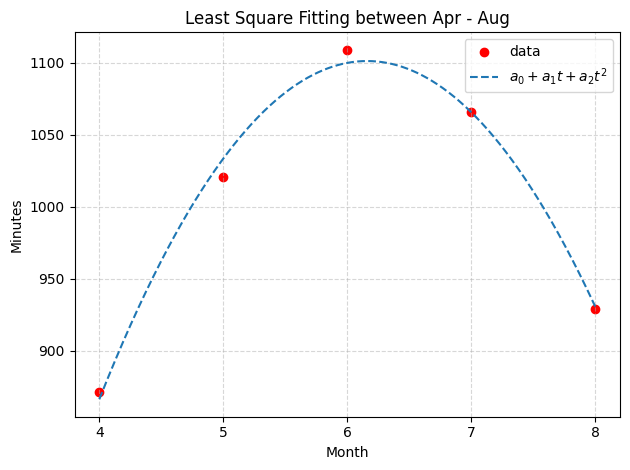

Least squares polynomial fit (degree 3)
Coefficients:
  a0: -287.942857
  a1:  341.452381
  a2: -2.357143
  a3: -2.666667
||r||_2:  1.266942e+01
SE (sum of squared errors):  1.605143e+02
RMSE:  5.665938e+00
Condition number k = 2305585680.240532


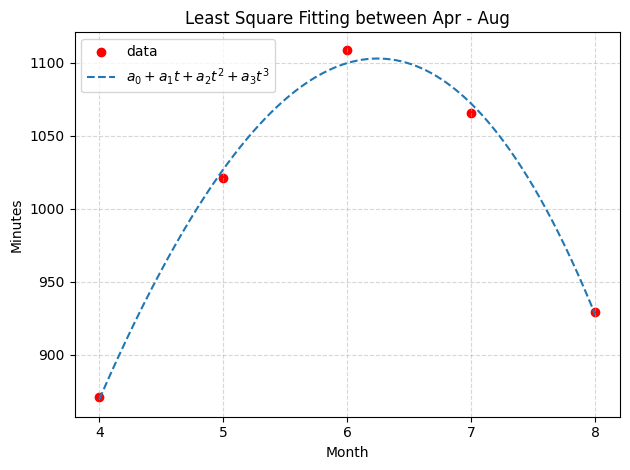

Least squares trigonometric fit: d0 + d1*cos(ωt) + d2*sin(ωt)
ω = 0.523599
Coefficients:
  d0:  741.583333
  d1: -349.054760
  d2: -34.470829
||r||_2:  4.249865e+01
SE (sum of squared errors):  1.806135e+03
RMSE:  1.226830e+01
Condition number k = 2.000000000000001


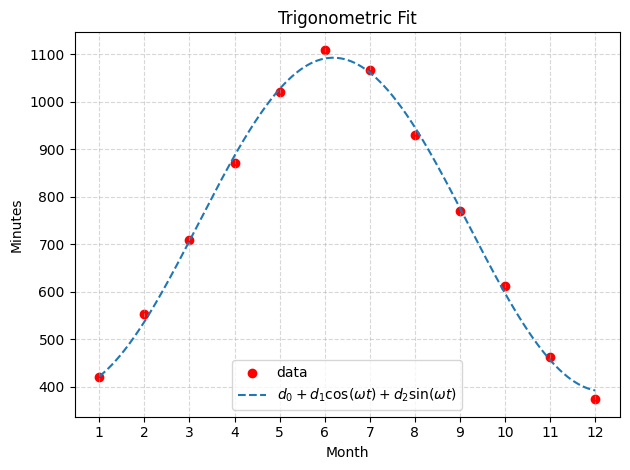

In [ ]:
def least_square_polynomial(
    x: np.ndarray,
    y: np.ndarray,
    degree: int,
    summary: bool = False,
) -> np.ndarray:
    """
    Solve the linear least squares problem for polynomial fit:
    y ≈ a0 + a1*x + a2*x^2 + ... + a_degree*x^degree

    Constructs the design matrix A = [1  x  x^2  ...  x^degree],
    builds the normal equations (A^T A) a = A^T y,
    and solves for the coefficient vector a in the least squares sense.

    Parameters:
    -----------
    x : 1D array of independent variable values
    y : 1D array of dependent variable values
    degree : int, degree of polynomial to fit
    summary : bool, whether to print summary statistics

    Returns:
    --------
    a : coefficient vector [a0, a1, ..., a_degree]
    """
    if x.shape != y.shape:
        raise ValueError("x and y must have the same shape")
    if x.ndim != 1:
        raise ValueError("x and y must be 1D arrays")
    n = x.size
    if n < degree + 1:
        raise ValueError(
            f"At least {degree + 1} data points required for degree {degree}"
        )

    # Build design matrix: each column is x^k for k = 0, 1, ..., degree
    # A[i, j] = x[i]^j
    A = np.column_stack([x**k for k in range(degree + 1)])

    y_vec = y.reshape(n, 1)
    AT = A.T

    # Solve normal equations
    a = np.linalg.solve(AT @ A, AT @ y_vec)

    # Compute residuals and error metrics
    r = y_vec - A @ a
    r_2norm = np.linalg.norm(r, 2)
    SE = float(r_2norm**2)  # Sum of squared errors
    # SE_2 = SSE(r)
    # print('SE comparison:', SE, SE_2) # Compare my way with Lucianos
    RMSE = float(np.sqrt(SE / len(r)))
    k_ATA = np.linalg.cond(AT @ A, p=np.inf)

    if summary:
        print(f"Least squares polynomial fit (degree {degree})")
        print("Coefficients:")
        for i, coef in enumerate(a.flatten()):
            print(f"  a{i}: {coef: .6f}")
        print(f"||r||_2: {r_2norm: .6e}")
        print(f"SE (sum of squared errors): {SE: .6e}")
        print(f"RMSE: {RMSE: .6e}")
        print(f"Condition number k = {k_ATA}")

    return a


apr_aug = t[3:8]
apr_aug_dense = np.linspace(4, 8, 1000)
apr_aug_data = sun_data[3:8]
# print(apr_aug, apr_aug_data)

# 2nd degree LS-polynomial ansatz
a = least_square_polynomial(apr_aug, apr_aug_data, 2, True)
model_2degree = poly.Polynomial(a.flatten())
plot_model(
    apr_aug,
    apr_aug_data,
    model_2degree,
    apr_aug_dense,
    "Least Square Fitting between Apr - Aug",
    r"$a_0 + a_1 t + a_2 t^2$",
)

# 3rd degree LS-polynomial ansatz
b = least_square_polynomial(apr_aug, apr_aug_data, 3, True)
model_3degree = poly.Polynomial(b.flatten())
plot_model(
    apr_aug,
    apr_aug_data,
    model_3degree,
    apr_aug_dense,
    "Least Square Fitting between Apr - Aug",
    r"$a_0 + a_1 t + a_2 t^2 + a_3 t^3$",
)


# LS Trig ansatz


def least_square_trig(
    x: np.ndarray,
    y: np.ndarray,
    omega: float,
    summary: bool = False,
) -> np.ndarray:
    """
    Fit a trigonometric model: y ≈ d0 + d1*cos(ωx) + d2*sin(ωx)

    Parameters:
    -----------
    x : 1D array of independent variable values
    y : 1D array of dependent variable values
    omega : angular frequency ω
    summary : bool, whether to print summary statistics

    Returns:
    --------
    d : coefficient vector [d0, d1, d2]
    """

    if x.shape != y.shape:
        raise ValueError("x and y must have the same shape")
    if x.ndim != 1:
        raise ValueError("x and y must be 1D arrays")
    n = x.size
    if n < 3:
        raise ValueError("At least 3 data points required")

    # Build design matrix: A = [1  cos(ωx)  sin(ωx)]
    A = np.column_stack([np.ones(n), np.cos(omega * x), np.sin(omega * x)])

    y_vec = y.reshape(n, 1)
    AT = A.T

    # Solve normal equations
    d = np.linalg.solve(AT @ A, AT @ y_vec)

    # Compute residuals and error metrics
    r = y_vec - A @ d
    r_2norm = np.linalg.norm(r, 2)
    SE = float(r_2norm**2)
    RMSE = float(np.sqrt(SE / len(r)))
    k_ATA = np.linalg.cond(AT @ A, p=np.inf)

    if summary:
        print("Least squares trigonometric fit: d0 + d1*cos(ωt) + d2*sin(ωt)")
        print(f"ω = {omega:.6f}")
        print("Coefficients:")
        print(f"  d0: {d[0, 0]: .6f}")
        print(f"  d1: {d[1, 0]: .6f}")
        print(f"  d2: {d[2, 0]: .6f}")
        print(f"||r||_2: {r_2norm: .6e}")
        print(f"SE (sum of squared errors): {SE: .6e}")
        print(f"RMSE: {RMSE: .6e}")
        print(f"Condition number k = {k_ATA}")

    return d


def trig_LS_model(coefficients: np.ndarray, omega: float):
    """
    Returns a function p(t) = d0 + d1*cos(ωt) + d2*sin(ωt)
    """

    def model(t_vals):
        return (
            coefficients[0]
            + coefficients[1] * np.cos(omega * t_vals)
            + coefficients[2] * np.sin(omega * t_vals)
        )

    return model


w = (2 * np.pi) / 12
d = least_square_trig(t, sun_data, w, True)
trig_model = trig_LS_model(d, w)


t_dense = np.linspace(1, 12, 1000)
plot_model(
    t,
    sun_data,
    trig_model,
    t_dense,
    "Trigonometric Fit",
    r"$d_0 + d_1 \cos(\omega t) + d_2 \sin(\omega t)$",
)


## 2.f) Compare condition numbers and comment on results

### Interpolation Methods:

| Method | K(A) |
|--------|----------|
| Naive ansatz | 1.16 × 10¹⁶ |
| Centered ansatz | 4.95 × 10⁸ |
| Newton's ansatz | 2.17 × 10⁸ |

### Least Squares Methods:

| Method | K(AᵀA) |
|--------|----------|
| 2nd degree polynomial (Apr-Aug) | 1.20 × 10⁶ |
| 3rd degree polynomial (Apr-Aug) | 2.31 × 10⁹ |
| Trigonometric fit (all data) | 2.00 |



### Comments:

**Different systems being compared**: Interpolation solves `A@c = y` (square system), while least squares solves `(AᵀA)@c = Aᵀy` (normal equations), which is why we calculate K(AᵀA) and not K(A).

**The trigonometric model shows superb conditioning** (K ≈ 2) - the design matrix with `[1, cos(ωt), sin(ωt)]` is nearly orthogonal *(Orthogonality of sines)*.

**Interpolation results in ill-conditioned methods**: All three interpolation methods have large condition numbers, with the naive ansatz being catastrophically ill-conditioned implying numerical instability. They also show signs of Runge's phenomena between datapoints 1 & 2.

**Least squares is better conditioned**: Using fewer data points (5 vs 12) with lower-degree polynomials gives much better conditioning than interpolating all 12 points.

**Recommendation:** The trigonometric model is best - it has superior numerical stability (K = 2), it uses all available data effectively and most closely predicts the experimental data.